#  Training Data for Baseline Logit model

In [20]:
import datetime
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
'''for implementing simple logisticregression'''
import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
'''for saving models'''
from joblib import dump

In [2]:
# MANIFEST - list of versions on board 
import sys
import os
print(pd.datetime.now())
print('OS: '+os.uname().sysname)
print('Python: '+sys.version)
print('numpy: '+np.__version__)
print('pandas: '+pd.__version__)
print('sklearn: '+sklearn.__version__)

2020-01-09 15:30:41.730379
OS: Linux
Python: 3.6.7 | packaged by conda-forge | (default, Nov  6 2019, 16:19:42) 
[GCC 7.3.0]
numpy: 1.17.3
pandas: 0.25.3
sklearn: 0.22.1


In [3]:
ROOT="../mortality_prediction_docker_model/v2/"
FOLDER = 'scratch/'
FILE_STR = 'train'

In [4]:
def add_prediction_date(file_name):
    '''given a patient's visit records, this function returns the prediction_date '''
    '''and whether this patient has a death record (1) or not(0)'''
    '''output is a reduced visit file'''
    visit = pd.read_csv(ROOT+'train/visit_occurrence.csv')
    cols = ['person_id','visit_start_date']
    visit = visit[cols]
    death = pd.read_csv(ROOT+'train/death.csv')
    cols = ['person_id','death_date']
    death = death[cols]
    visit_death = pd.merge(death,visit,on=['person_id'],how='inner')
    visit_death['death_date'] = pd.to_datetime(visit_death['death_date'], format='%Y-%m-%d')
    visit_death['visit_start_date'] = pd.to_datetime(visit_death['visit_start_date'], format='%Y-%m-%d')
    visit_death['last_visit_death'] = visit_death['death_date'] - visit_death['visit_start_date']
    visit_death['last_visit_death'] = visit_death['last_visit_death'].apply(lambda x: x.days)
    visit_death = visit_death.loc[visit_death['last_visit_death'] <= 180]
    visit_death.drop_duplicates(subset=['person_id'], keep = 'first',inplace = True)
    visit_death = visit_death[['person_id','visit_start_date']]
    visit_death.columns = ['person_id','prediction_date']
    visit_death['death'] = np.ones(visit_death.shape[0])
    visit_live = visit[~visit.person_id.isin(visit_death.person_id)]
    visit_live = visit_live[['person_id','visit_start_date']]
    '''
    for patients in the negative case, select patients' latest visit record
    '''
    visit_live = visit_live.sort_values(['person_id','visit_start_date'],ascending=False).groupby('person_id').head(1)
    visit_live = visit_live[['person_id','visit_start_date']]
    visit_live.columns = ["person_id", "prediction_date"]
    visit_live['death'] = np.zeros(visit_live.shape[0])
    prediction_date = pd.concat([visit_death,visit_live],axis=0)
    prediction_date.to_csv(file_name[0:-4] + '_prediction_date.csv',index=False)
    print("last visit date selected", flush = True)
    return prediction_date

In [5]:
def add_demographic_data(file_name, prediction_date):
    '''add demographic data including age, gender and race'''
    person = pd.read_csv(ROOT+'train/person.csv')
    prediction_date = pd.read_csv(file_name)
    cols = ['person_id','gender_concept_id','year_of_birth','race_concept_id']
    person = person[cols]
    person_prediction_date = pd.merge(prediction_date,person,on=['person_id'], how='left')
    person_prediction_date['prediction_date'] = person_prediction_date['prediction_date'].astype('datetime64[ns]')
    person_prediction_date = person_prediction_date.dropna(subset=['year_of_birth'])
    person_prediction_date['year_of_birth'] = person_prediction_date['year_of_birth'].astype('datetime64[ns]')
    person_prediction_date['age'] = person_prediction_date['prediction_date'] - person_prediction_date['year_of_birth']
    person_prediction_date['age'] = person_prediction_date['age'].apply(lambda x: x.days/365.25)
    print("patients' ages are calculated", flush = True)
    person["count"] = 1
    gender = person.pivot(index = "person_id", columns="gender_concept_id", values="count")
    gender.reset_index(inplace = True)
    gender.fillna(0,inplace = True)
    race = person.pivot(index ="person_id", columns="race_concept_id", values="count")
    race.reset_index(inplace = True)
    race.fillna(0,inplace = True)
    race = race[['person_id', 8516, 8515, 8527, 8557, 8657]]
    gender = gender[['person_id',8532]]
    print("patients' gender and race information are added", flush = True)
    scaler = MinMaxScaler(feature_range = (0, 1), copy = True)
    scaled_column = scaler.fit_transform(person_prediction_date[['age']])
    person_prediction_date = pd.concat([person_prediction_date, pd.DataFrame(scaled_column,columns = ['scaled_age'])],axis=1)
    mortality_predictors = person_prediction_date[['death','person_id','scaled_age']]
    mortality_predictors = mortality_predictors.merge(gender, on = ['person_id'], how = 'left')
    mortality_predictors = mortality_predictors.merge(race, on = ['person_id'], how = 'left')
    mortality_predictors.fillna(0,inplace = True)
    mortality_predictors.to_csv(file_name[0:-4] + '_plus_demographic_data.csv',index = False)
    return mortality_predictors

In [6]:
def logit_model(filename):
    '''
    apply logistic regression models for selected demographics features and use GridSearchCV to optimize parameters
    '''
    data = pd.read_csv(filename,low_memory = False).dropna(axis = 0,how = 'any')
    X = data.drop(['death','person_id'], axis = 1)
    features = X.columns.values
    Y = data[['death']]
    X = np.array(X)
    Y = np.array(data[['death']]).ravel()
    clf = LogisticRegressionCV(cv = 3, penalty = 'l2', tol = 0.0001, fit_intercept = True, intercept_scaling = 1, class_weight = None, random_state = None,
    max_iter = 100, verbose = 0, n_jobs = None).fit(X,Y)
    dump(clf, ROOT+'/model/baseline.joblib')
    print("Training stage finished", flush = True)
    return clf

In [7]:
prediction_date = add_prediction_date(ROOT + FOLDER + FILE_STR + '.csv')
mortality_predictors = add_demographic_data(ROOT + FOLDER + FILE_STR + '_prediction_date.csv', prediction_date)

last visit date selected
patients' ages are calculated
patients' gender and race information are added


In [8]:
train_file = ROOT + FOLDER + FILE_STR + '_prediction_date_plus_demographic_data.csv'
clf = logit_model(train_file)

Training stage finished


In [9]:
data = pd.read_csv(train_file,low_memory = False).dropna(axis = 0,how = 'any')
X = data.drop(['death','person_id'], axis = 1)
features = X.columns.values
Y = data[['death']]
X = np.array(X)
Y = np.array(data[['death']]).ravel()

y_scores = clf.predict(X)

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

roc_auc_score(Y, y_scores)

0.5

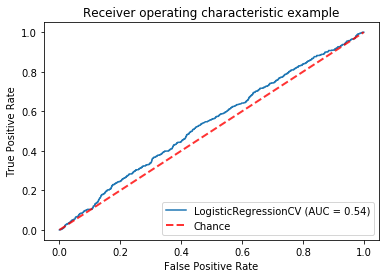

In [22]:
#from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

fig, ax = plt.subplots()
plot_roc_curve(clf, X, Y, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()